## ROS 2의 인증, 액세스 제어, 암호화 기능

ROS2CLI강좌에서 간단히 설명한 ROS2CLI 중 'ros2 security' 명령어가 SROS2 유틸리티이다. 이 장에서는 SROS2 유틸리티를 사용해보면서 SROS2의 핵심 기능인 인증, 액세스 제어, 암호화 기능에 대해 알아보도록 하겠다.

# 노드 인증

ROS 2 네트워크에 참가하는 노드들을 인증하여 참여 불가 판정을 하는 것으로 공개키(public key) 및 개인키(private key)가 요구된다. 만약 인증되지 않은 노드가 ROS 2 네트워크에 참가하려하면 접속은 거부 된다. 노드 인증 기능의 사용에 있어서 사용할 패키지 및 노드의 소스 코드 변경은 전혀 필요 없다. 그 대신에 암호키 및 보안 파일과 'ROS 2 sercurity' 명령어를 사용하여 보안 설정을 하게 된다. 우선 다음과 같이 암호키 등의 보안 설정을 보관하는 폴더를 생성한다.

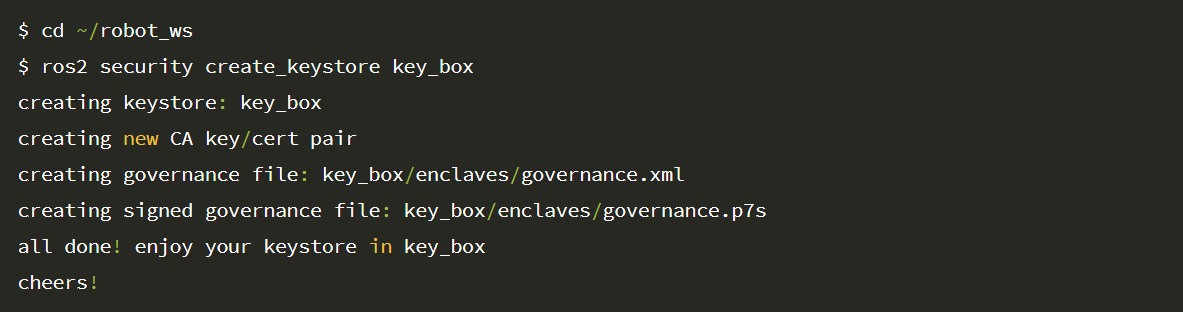

image.png

이 명령어로 key_box라는 폴더가 생성되고 그 안에 아래와 같은 거버넌스, 개인키, 공개키와 같은 4개의 파일과 링크 파일 4개가 자동 생성하게 된다. 이러한 파일 생성에는 OpenSSL을 사용하고 있다.

image.png

다음으로 노드 인증 기능을 테스트할 talker 노드와 listener 노드을 위해 암호키와 인증서를 생성한다.

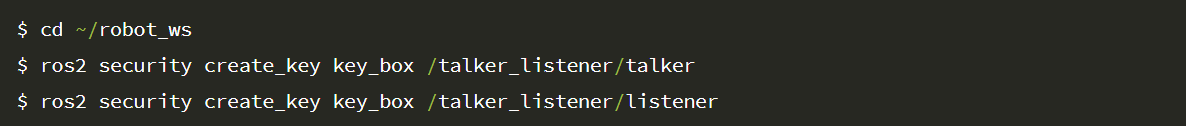

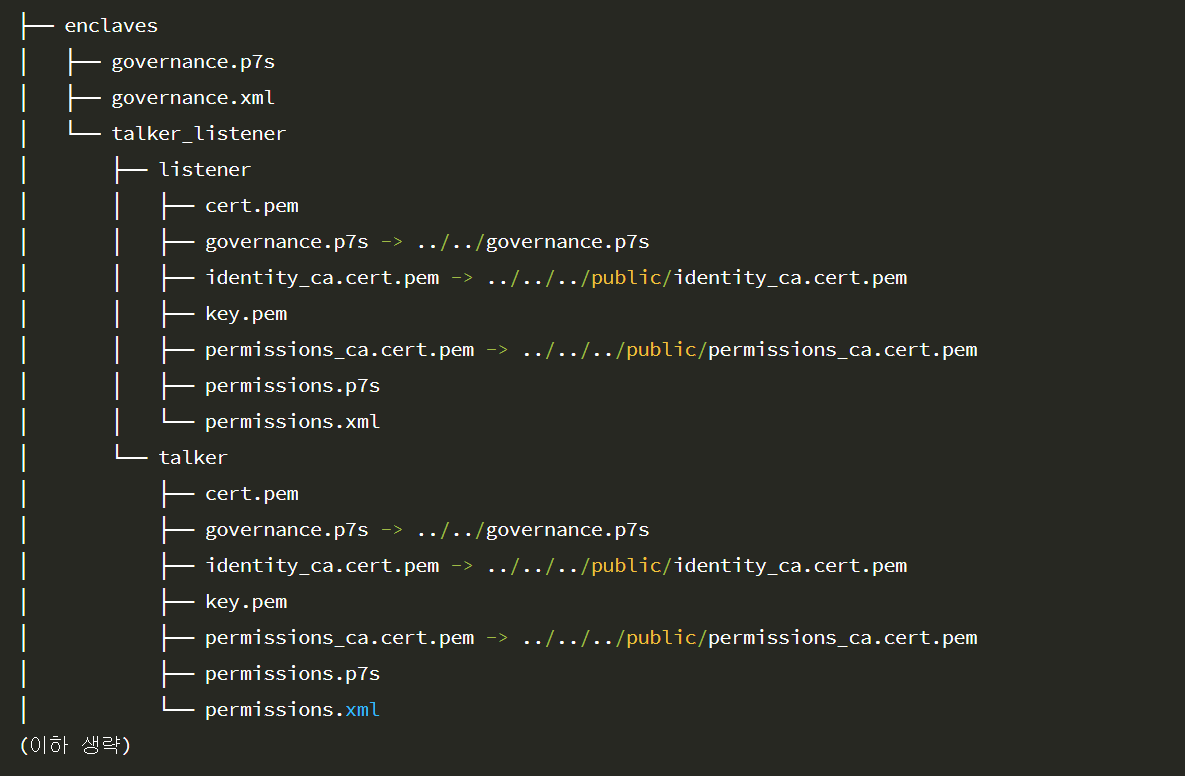

그 후 다음과 같이 터미널 창에서 'export' 명령로 SROS2 환경 변수 (ROS_SECURITY_xxxxx)를 선언하여 ROS 2 보안 설정을 한다. SROS2 환경 변수에는 하기와 같이 'ROS_SECURITY_KEYSTORE', 'ROS_SECURITY_ENABLE', 'ROS_SECURITY_STRATEGY'의 3가지가 있다.

1) 'ROS_SECURITY_KEYSTORE': 보안 설정 파일을 보관하는 폴더를 지정하는 것으로 위에서 'create_keystore'으로 지정한 폴더의 경로를 넣어주면 된다.

2) 'ROS_SECURITY_ENABLE': 보안 설정의 On/Off 기능으로 true/false 형태로 설정하게 된다. 디폴트 설정 값은 false으로 지금까지 이 설정을 사용하지 않았다면 ROS2의 Security 기능을 사용하고 있지 않았던 것이다.

3) 'ROS_SECURITY_STRATEGY': 보안 설정 방법에 대한 것으로 Enforce으로 설정하게 되면 보안 설정 파일이 없는 메시지 통신은 금지하고 Permissive의 경우 비보안 참여자로 참여 시킨다. 보안 설정 파일을 찾을 수 없는 경우를 대비하여 Permissive이 아닌 Enforce 옵션을 사용하자.

참고로 이러한 환경 변수는 노드를 실행할 때 마다 매번 각 터미널에서 선언해야 한다. 이어지는 노드 실행 명령어들을 실행하기 전에 꼭 다음 3가지 환경 변수는 각 터미널창에서 실행해주는 것을 잊지 않도록 하자. 만약 ROS 2의 보안 기능을 지속적으로 사용할 예정이라면 편의를 위해 3가지 환경 변수를 '~/.bashrc'에 추가해두면 편리하게 사용할 수 있다.

image.png

자~ 그러면 talker 노드와 listener 노드를 실행해보자. enclave라는 ROS arguments는 위에서 'ros2 security create_key' 명령어를 통해 각 노드를 위해 생성한 암호키와 인증서를 담은 폴더를 지정하는 것이다. 2개의 노드가 인증되어 접속되어 메시지를 주고 받는 것을 확인할 수 있다.

그리고 다음의 예제에서는 demo_nodes_cpp 패키지와 demo_nodes_py 패키지의 서로다른 언어로 작성된 노드를 실행시켜보았다. 이를 통해 클라이언트 라이브러리의 종류에 의존하지 않는다는 것도 확인할 수 있었다. SROS2는 C++, Python 언어의 노드 간에도 상관없이 사용 가능하다.

In [ ]:
ros2 run demo_nodes_cpp talker --ros-args --enclave /talker_listener/talker

In [ ]:
ros2 run demo_nodes_py listener --ros-args --enclave /talker_listener/listener

암호키는 노드 이름을 기반으로 생성되기에 노드 이름을 변경하게 되면 노드 인증에 실패하게 된다. 다음과 같이 listener 노드를 실행할 때 listener2라는 이름으로 노드 이름을 변경하여 실행해보자. 그러면 다른 이름으로 노드가 실행되어 노드 인증에 실패하기에 ROS 2 네트워크에 참가가 거부되는 것을 확인할 수 있다.

In [ ]:
ros2 run demo_nodes_py listener --ros-args -r __node:=listener2 --enclave /talker_listener/listener

참고로 위 명령어를 실행하게 되면 기존에 동작 중이던 talker 노드와 listener 노드가 종료되면서 아래와 같은 에러를 남기게 된다.

image.png

# 액세스 제어

액세스 제어는 지정한 네임스페이스, 토픽, 서비스, 액션에 대해 송신, 수신, 실행을 UNIX 퍼미션 같은 개념으로 쓰기, 읽기, 실행 등의 허가/거부를 설정할 수 있게 되었다. 이 퍼미션 설정은 XML 포맷으로 파일로 만들어 액세스 제어 방침(policy)으로 관리할 수 있다. 각 태그의 의미는 다음과 같다.

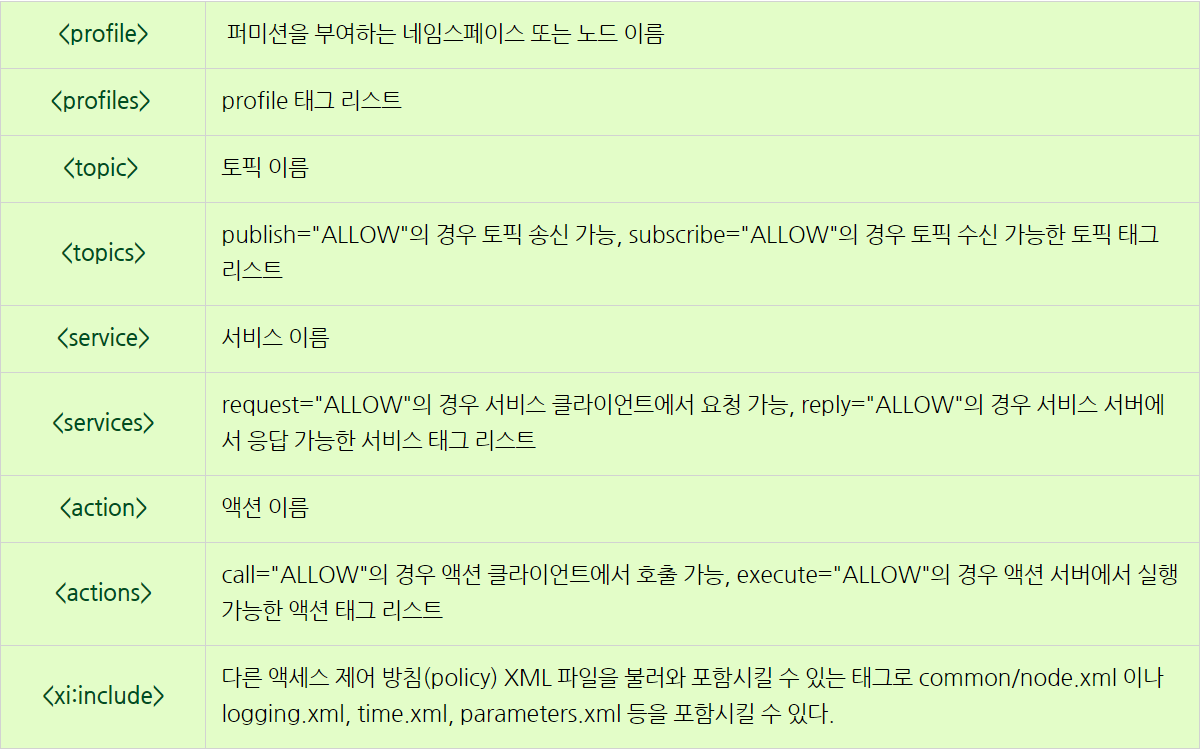

참고로 publish, subscribe, request, reply, call, execute 등과 같은 퍼미션의 디폴트 값은 "DENY"이다. 이는 모든 억세스를 거부하도록 설정하게 되어 있다. 이 때문에 퍼미션 파일에서는 허가할 부분의 것만 "ALLOW"으로 설정하면 된다.

예제로 제공되는 액세스 제어 방침 파일을 보며 각 태그의 기능을 이해하면 더 쉽게 이해할 수 있는데 다음의 명령어를 이용하여 SROS2 리포지토리의 policies 폴더를 다운로드 하자. 이 폴더 안에 sample.policy.xml 파일과 talker_listener.policy.xml 파일을 참고 삼아 보도록 하자.

* 참고로 위 명령어에서 'git clone'이 아닌 subversion의 'svn checkout' 명령어를 사용한 이유는 지정 리포지토리의 특정 폴더만 다운로드 하기 위해서이다. 특정 파일이나 폴더만을 다운로드 받을 때 유용한 명령어이니 알아두도록 하자.

sample.policy.xml

https://github.com/ros2/sros2/blob/foxy/sros2/test/policies/sample.policy.xml

talker_listener.policy.xml

https://github.com/ros2/sros2/blob/foxy/sros2/test/policies/talker_listener.policy.xml


위 sample.policy.xml 및 talker_listener.policy.xml 만을 예로 들었는데 이 이외에도 <xi:include> 태그를 이용하여 logging.xml, time.xml, parameters.xml 등도 호출하고 있다. 이것들은 하기 리포지토리에서 확인해보기를 추천한다. 여기서는 rosout와 같은 logging을 허가할지 거부할지 선택하고 clock, get_parameters 및 set_parameters과 같은 파라미터 관련 service의 퍼미션을 설정하게 되어 있다.

SROS2's policies

https://github.com/ros2/sros2/tree/foxy/sros2/test/policies

XML 퍼미션 파일의 생성 명령어는 다음과 같다. 퍼미션 설정은 위에서 예로 설명한 'policies/sample.policy.xml'에 기재된 내용을 기반으로 permissions.xml 퍼미션 파일과 permissions.p7s 인증된 퍼미션 파일을 새로 생성하였다.

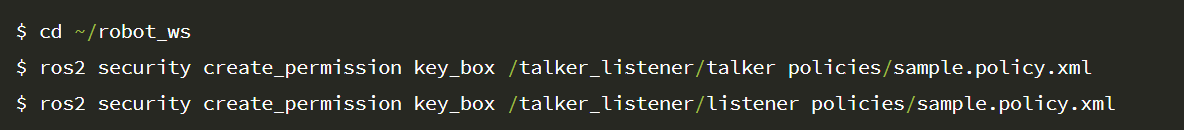

퍼미션 설정으로 기존 퍼미션 파일과 신규 작성한 퍼미션 파일이 달라졌음을 아래와 같이 확인할 수 있다. 이전 파일은 특정 토픽명을 지정하지 않았기에 모든 토픽이 "ALLOW" 이지만 변경 후에는 /chatter 토픽만을 허가하게 되었다.

[이전 파일]

image.png

[신규 파일]

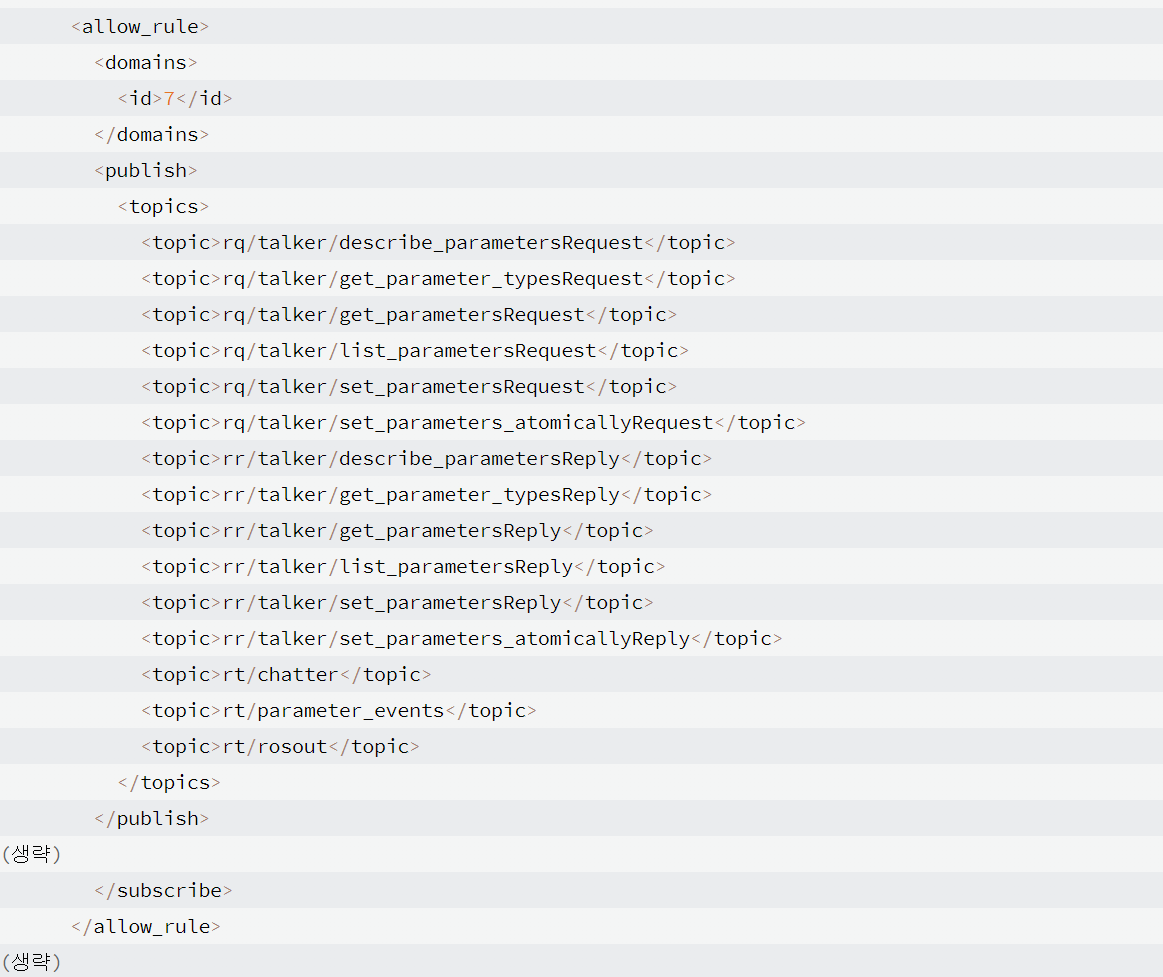

신규 XML 퍼미션 파일 생성 후에 아래의 명령어로 talker 노드와 listener 노드를 실행시켜보자. 참고로 '-e'는 위 노드 인증 예제에서 사용했던 '--enclave' 옵션과 동일한 것으로 '-e'으로 단축하여 사용할 수 있다.

In [ ]:
ros2 run demo_nodes_cpp talker --ros-args -e /talker_listener/talker

In [ ]:
ros2 run demo_nodes_py listener --ros-args -e /talker_listener/listener

다음 예제에서는 실행하고 있던 listener 노드를 종료하고 새로 listener 노드를 실행해보자. 이번에는 'chatter' 이라는 토픽 이름을 'new_chatter' 으로 변경해본 것이다. 이를 실행해보면 이전에 실행시켰던 예제와는 달리 이번 예제에서는 퍼미션으로 지정한 '/chatter' 토픽에 한정하여 메시지 송/수신을 허가하였기에 다른 토픽 이름으로는 실행이 불가능 하다는 것을 확인할 수 있다. 이는 노드 인증에서 다루었던 노드 하나의 인증보다 더 강한 보안 설정을 할 수 있게 된 것을 확인할 수 있다. 이러한 것을 SROS2에서 억세스 제어라고 한다.

In [ ]:
 ros2 run demo_nodes_py listener --ros-args -r chatter:=new_chatter -e /talker_listener/listener

참고로 위 명령어처럼 토픽명을 바꾸어 실행하게 되면 아래와 같은 에러를 남기며 실행이 중단된다.

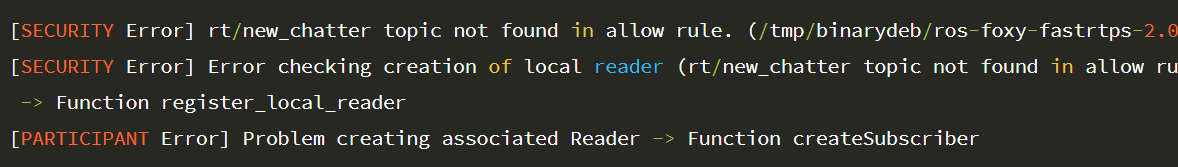

# 다른 컴퓨터에서 SROS2 사용하기

지금까지의 예제는 하나의 컴퓨터에서 SROS2의 노드 인증과 액세스 제어와 관련한 테스트였다. 이러한 SROS2 기능은 단일 컴퓨터에서 사용되기 보다는 네트워크를 경유하는 복수의 컴퓨터 간에 연결된 경우에 더 중요한 역할을 하게 된다. 실제로 다른 컴퓨터 간의 메시지 통신에서 보안 기능이 동작하는지 알아보자.

지금까지 SROS2 예제를 실행했던 컴퓨터가 robot1이고 robot1 컴퓨터의 IP가 192.168.1.10 이라고 하고, 새로운 컴퓨터인 robot2 컴퓨터가 192.168.1.20 의 IP라고 가정한다면 다음과 같이 테스트할 수 있다.

우선 robot1 컴퓨터에서 robot2 컴퓨터로 ssh로 접속하여 robot_ws 폴더에 key_box 폴더를 만들어 두자. 그 다음 robot2 컴퓨터와의 접속을 해제한 후 scp 명령어를 이용하여 robot2 컴퓨터에 robot1 컴퓨터에 생성해둔 암호키 파일들과 인증서를 담았던 key_box 폴더 전체를 복사하여 옮겨놓자.

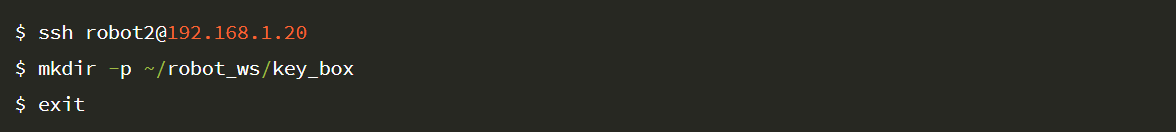

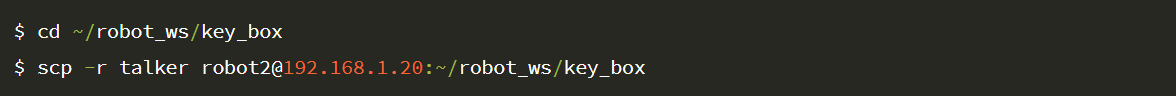

그 뒤 다음과 같이 robot1 컴퓨터에서는 talker 노드를 robot2 컴퓨터에서는 listener 노드를 실행 시키면 문제없이 메시지 통신이 이루어지는 것을 확인할 수 있다. 만약 robot2 컴퓨터에서 key_box 폴더를 삭제하여 암호키 파일들과 인증서가 없는 상태에서 다시 실행시켜 보면 메시지 통신이 되지 않는 것도 확인할 수 있다.

[robot1]

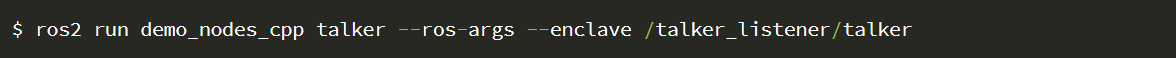

[robot2]

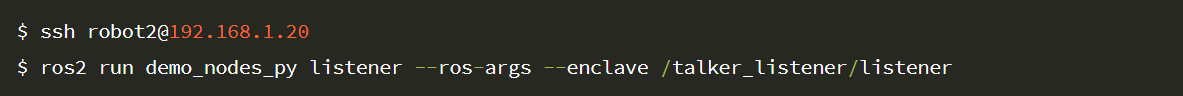

# 다른 DDS 벤더로 SROS2 사용하기

ROS 2의 보안 기능은 DDS Security의 기능을 이용하여 구현되어 있기 때문에 이것들의 보안 기능은 DDS 벤더에 의존하지 않는다. 이전에 설명했던 것처럼 실행시에 다른 DDS 벤더를 실행해도 문제없이 노드 인증이나 억세스 제어가 되었다. talker 노드와 listener 노드를 실행할 때 아래 중에 한개씩 다른 DDS 벤더들을 선택하여 실행해보자.

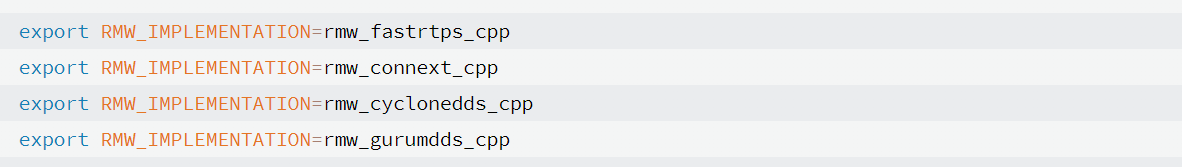

# 보안 vs 성능

SORS2를 사용하게 되면 ROS 2 네트워크를 통해 이루어지는 모든 메시지 통신에 보안을 강화시킬 수 있다. 이는 이 강좌의 서두에서 말했었지만 ROS 2를 이용하는 제품을 상용화하는데 있어서 매우 중요한 기능이라고 볼 수 있다. 하지만 보안 기능을 활성화하면 기본 메시지에 더하여 오버헤드 데이터가 추가되고 그로인해 지연시간과 대역폭에 영향을 주게된다. 이는 어쩔 수 없는 트레이드-오프 관계이다.

아래의 그림은 참고자료의 결과로 No Security, Cryptographic Alg (SROS2), SSL/TLS (VPN)을 유선 환경/무선 환경에 대해 지연시간과 대역폭의 차이를 비교한 것이다. ROS 2에서 보안 기능이 비활성화된 No Security 상태와 보안 기능을 활성화한 Cryptographic Alg (SROS2) 상태의 비교 결과를 보면 지연시간과 대역폭 모두 상당히 차이가 난다는 것을 볼 수 있다.

'Robot Operating System 2: The need for a holistic security approach to robotic architectures'에서도 보안 기능을 사용하면 사용하지 않을 때에 비해 지연시간은 5배 더 발생되고 대역폭은 1/5로 감소하는 것으로 나왔다. 이를 보았을 때 상용화가 아닌 이상에야 보안 기능을 끄고 개발하는게 좋을 것 같으며 상용화를 준비한다면 보안 기능을 빠질 수 없기에 네트워크를 통해 사용하는 메시지를 줄이고 간소화시키는 것이 필요해보인다.

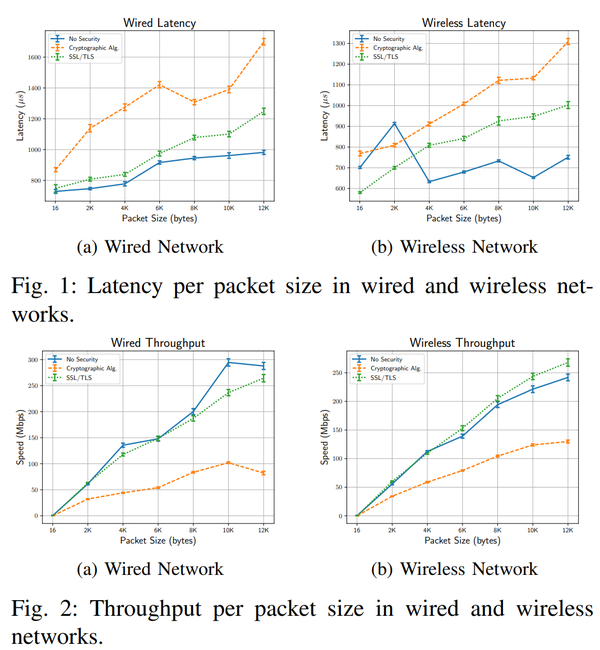

# ROS 2 Robotic Systems Threat Model

ROS 2 디자인 문서 중  ROS 2 Robotic Systems Threat Model 문서에는 ROS 2를 이용하는 로봇 또는 로봇 시스템의 보안 취약점을 분석할 수 있는 기준을 마련해두고 있다.

이 로봇 시스템(robotic system) 위협 모델(threat model)의 대상은 하나 이상의 액추에이터(actuator) 또는 센서(sensor)에 연결된 하나 이상의 범용 컴퓨터를 로봇 시스템으로 정의하였으며, 액추에이터를 물리적 동작을 생성하는 모든 장치로 정의하고, 센서는 물리적 속성을 캡처하거나 기록하는 모든 장치로 정의하였다.

그리고 분석 요소로 액터(Actors), 자산(Assets), 진입점(Entry Points)이라 정의하고 있는데 액터는 로봇과 상호 작용하는 인간 또는 외부 시스템이라 정의하고 어떤 액터가 로봇과 상호 작용하는지 분석하여 로봇 시스템이 어떻게 손상 될 수 있는지 결정하는데 사용하고 있다. 예를 들어, 액터는 로봇 시스템을 공격하기 위해 악용 될 수있는 내부/외부 명령을 로봇에게 줄 수 있는 요소를 말한다. 자산은 공격자로부터 방어해야하는 시스템의 모든 사용자, 리소스 (예: 디스크 공간), 소유물(예: 사용자의 물리적 안전)으로 정의하였다. 예를 들어 센서 데이터는 시스템의 리소스/자산이며 해당 데이터의 개인 정보는 시스템 소유물이자 비즈니스 목표이다. 진입점은 시스템이 세계(통신 채널, API, 센서 등)와 상호 작용하는 방식이라 정의하고 있다.

이러한 로봇 시스템(robotic system) 위협 모델(threat model)의 대상과 분석 요소를 기반으로 다양한 위협 요소(threats)에 대해 위협 범주, 위협 위험 평가, 영향을 받는 자산, 영향을 받는 진입점별로 분석하고 점수 또는 체크를 하는 위협 분석 및 모델링(Threat Analysis and Modeling)을 이 문서에서는 제시하고 있다.

그리고, 위에서 제시한 위협 분석 및 모델링(Threat Analysis and Modeling)의 예로 모바일 로봇인 TurtleBot3와 매니퓰레이터인 MARA를 대상으로 한 분석 결과도 있으니 보안과 관련하여 관심있는 사람은 ROS 2 Robotic Systems Threat Model 문서를 읽어보도록 하자.

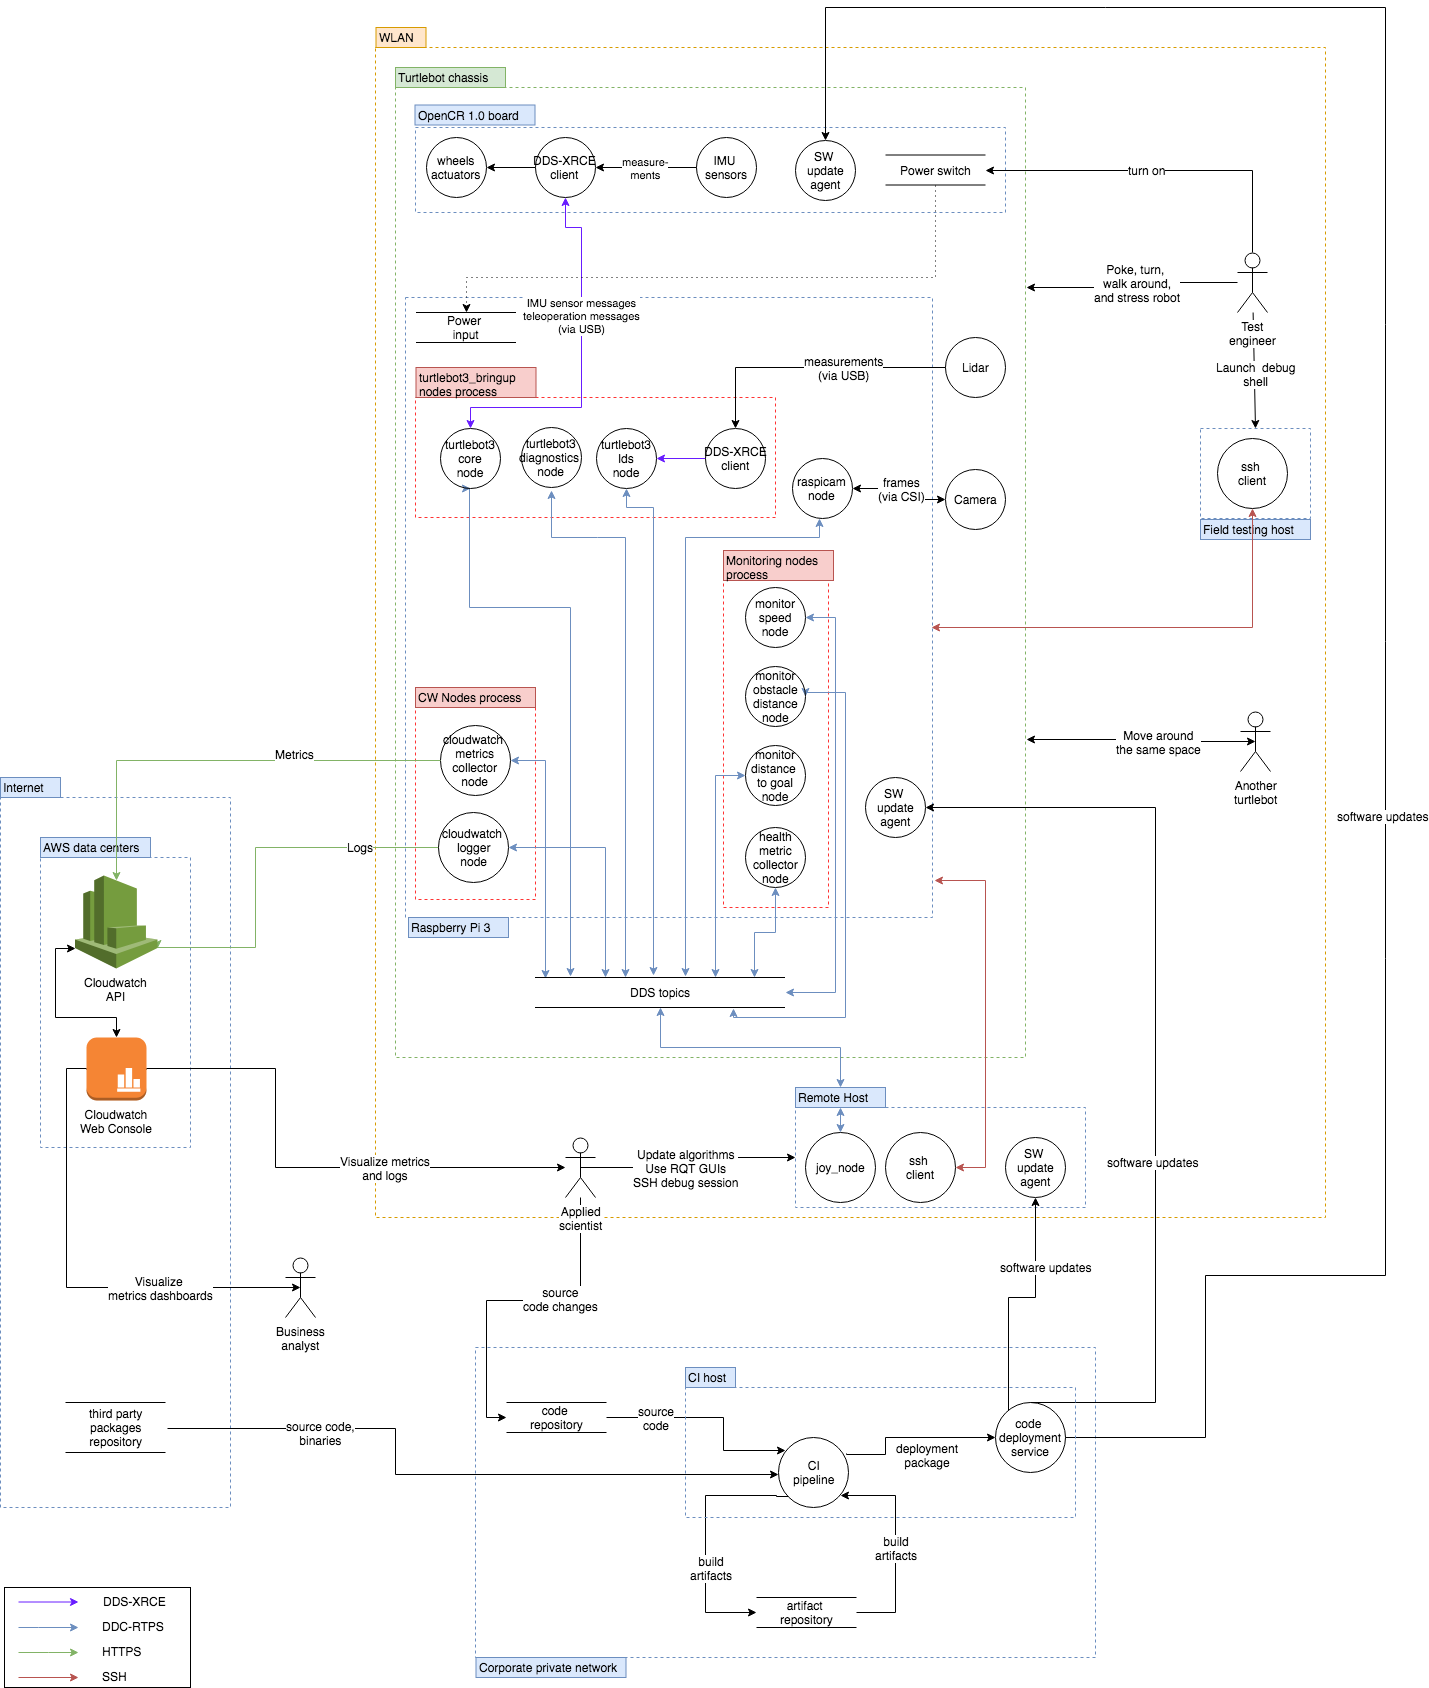